## Calculate ZDR Bias From QVP

### Imports and Functions

In [1]:
%matplotlib inline
import os, sys, glob, math, pathlib, gzip, shutil
import matplotlib.pyplot as plt
import numpy as np
from netCDF4 import num2date
import matplotlib.dates as mdates
import pyart
import xarray as xr

# ****************************************************************************************

def unzip_file(file):

    # Unzips input file
    file_unzip = os.path.basename(file)[0:-3]
    with gzip.open(file, 'rb') as f_in:
        with open(file_unzip, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

    return file_unzip    
        
# ***************************************************************************************

def retrieve_qvp(filename, flds = None):
    if flds == None:
        flds = ['RH','CZ','DR','KD']
    radar = pyart.io.read(filename)
    #gatefilter = pyart.filters.GateFilter(radar)
    #gatefilter.exclude_below('CZ', 30)
    
    desired_angle = 9.0
    index = abs(radar.fixed_angle['data'] - desired_angle).argmin()
    #radar_slice = radar.get_slice(index)
    #print(radar.fixed_angle['data'])
    #print(radar.elevation['data'][-1])
    qvp = {}
    for fld in flds:
        get_field = radar.get_field(index, fld)
        #this_fld = np.ma.masked_where(gatefilter.gate_excluded[radar_slice],get_field)
        #this_fld = np.ma.mean(this_fld, axis = 0)
        this_fld = radar.get_field(index, fld).mean(axis = 0)
        qvp.update({fld:this_fld})
    qvp.update({'range': radar.range['data'], 'time': radar.time})
    x,y,z = pyart.core.transforms.antenna_to_cartesian(qvp['range']/1000.0, 0.0, 
                                             radar.fixed_angle['data'][index])
    qvp.update({'height': z})
    del radar
    return qvp

# ****************************************************************************************

def get_time_series(qvps):

    # Create an empty dictionary to be filled
    time_series = {}

    # Work out how many profiles
    n_times = len(qvps)

    # Loop over all fields 
    for fld in ['RH','CZ', 'DR','KD']:
        # Create empty time series
        this_fld = np.full([n_times, len(qvps[0][fld])], np.nan)
    
        # Create time array
        times = np.full(n_times,np.nan)
    
        # Loop over all times
        for i in range(n_times):
        
            # Create a datetime object
            dateobj = num2date(qvps[i]['time']['data'][0], qvps[i]['time']['units'])
        
            # Append a numerical date using Matplotlib's time reference
            times[i] = mdates.date2num(dateobj)
        
            # Update the profile to the time series
            this_fld[i,:] = qvps[i][fld]
    
        # Append the time series to the dictionary
        time_series.update({fld: this_fld[times.argsort(), :]})
    #print(time_series)
    # Sort times    
    times.sort()

    return times, time_series

# ****************************************************************************************

def convert_to_xr(qvps,times, time_series):

    ds = xr.Dataset(
        {
        "DR": (["time", "height"], time_series["DR"]),
        "CZ": (["time", "height"], time_series["CZ"]),
        "RH": (["time", "height"], time_series["RH"]),
        "KD": (["time", "height"], time_series["KD"]), 
        },
        coords={
        "time": times,
        "height": qvps[0]['height']
        }
    )

    return ds

# ****************************************************************************************

def extract_height_data(ds, min_height, max_height):
    
    # Extract ZDR values in the region between min_height and max_height.
    
    height_data = ds['DR'].sel({'height': slice(min_height, max_height)})
    return height_data.values

# ****************************************************************************************

def calculate_zdr_offset(zdr_values):
    
    # Calculate the ZDR calibration offset. 
    mean_zdr = np.nanmean(zdr_values)
    
    # Subtract intrinsic value of ZDR in light rain (0.18 dB)
    offset = mean_zdr - 0.18
    return offset

# ****************************************************************************************

def apply_zdr_offset(zdr_values, offset):
    """
    Apply the ZDR calibration offset to the data.
    """
    calibrated_zdr = zdr_values - offset
    return calibrated_zdr

# ****************************************************************************************

def find_BB_height(ds):

    # Extract time, height, and radar variables
    time = ds["time"].values
    height = ds["height"].values
    reflectivity = ds["CZ"].values  
    zdr = ds["DR"].values 
    rhohv = ds["RH"].values
    kdp = ds["KD"].values

    # Initialize array to store BB base heights
    bb_base_heights = np.full(len(time), np.nan)

    # Loop through each time step to detect the bright band base
    for i in range(len(time)):
        Z_profile = reflectivity[i, :]
        ZDR_profile = zdr[i, :]
        RHOHV_profile = rhohv[i, :]
        KDP_profile = kdp[i, :]

        # Identify the bright band peak (maximum reflectivity)
        bb_peak_idx = np.argmax(Z_profile)

        # Identify the melting layer region (where RHOHV is lowest)
        rhohv_min_idx = np.argmin(RHOHV_profile[:bb_peak_idx + 5])  # Allow small buffer

        # Define the search region below the bright band peak
        search_region = slice(bb_peak_idx, len(height))

        # Compute reflectivity gradient
        dZ = np.gradient(Z_profile, height)

        # Find candidate BB base points:
        base_candidates = np.where(
            (dZ[search_region] < 20.0) & 
            (ZDR_profile[search_region] > 0.75) &  
            (RHOHV_profile[search_region] > 0.90) 
            #(RHOHV_profile[search_region] > 0.80) 
            )[0]

        # Select the first height BELOW the melting layer minimum where RHOHV recovers
        valid_base_indices = base_candidates[base_candidates > rhohv_min_idx]

        if len(valid_base_indices) > 0:
            bb_base_heights[i] = height[valid_base_indices[0] + bb_peak_idx]

    threshold=2
    filtered_bb = bb_base_heights[bb_base_heights >= 2000]
    #print(np.nanmean(bb_base_heights))
    #print(np.nanmean(filtered_bb))
    mean_data = np.nanmean(filtered_bb)
    std_data= np.nanstd(filtered_bb)
    filtered_data = filtered_bb[(filtered_bb > mean_data - threshold * std_data) & (filtered_bb < mean_data + threshold * std_data)]
    #mean_data = np.nanmean(bb_base_heights)
    #std_data= np.nanstd(bb_base_heights)
    #filtered_data = bb_base_heights[(bb_base_heights > mean_data - threshold * std_data) & (bb_base_heights < mean_data + threshold * std_data)]
    mean_bb = np.full(len(time), (np.nanmean(filtered_data)))

    return mean_bb, bb_base_heights

# ****************************************************************************************

def plot_data(plt_dir, times, ds_plot, qvps, mean_bb, offset, month, day, yy):

    calibrated_zdr = apply_zdr_offset(ds_plot.DR, offset)

    # Setup figure
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))

    pc1 = axes[0].pcolormesh(times, qvps[0]['height']/1000.0, 
                             ds_plot.DR.T, shading='auto', 
                             vmin = -0.5, vmax = 2.5,
                             cmap=pyart.graph.cm_colorblind.HomeyerRainbow)

    axes[0].plot(times, mean_bb/1000.0, 'k--', label="BB Base Mean", linewidth=2)
    axes[0].xaxis_date()
    #fig.autofmt_xdate()
    #axes[0].set_xlabel('Time (UTC)')
    axes[0].set_ylabel('Height (km)')
    axes[0].set_ylim([0,15])
    cb = plt.colorbar(pc1, ax=axes[0])
    cb.set_label('Mean Differential Reflectivity (dB)')
    axes[0].set_title(f'Mean Differential Reflectivity (dB) {month}/{day}/{yy}')
    axes[0].legend()
    axes[0].grid()


    pc2 = plt.pcolormesh(times,qvps[0]['height']/1000.0, 
                         calibrated_zdr.T, shading='auto',
                         vmin = -0.5, vmax = 2.5, 
                         cmap=pyart.graph.cm_colorblind.HomeyerRainbow)

    axes[1].plot(times, mean_bb/1000.0, 'k--', label="BB Base Mean", linewidth=2)
    axes[1].xaxis_date()
    fig.autofmt_xdate(rotation=0, ha='center')
    axes[1].set_xlabel('Time (UTC)')
    axes[1].set_ylabel('Height (km)')
    axes[1].set_ylim([0,15])
    cb = plt.colorbar(pc2, ax=axes[1])
    cb.set_label('Mean Differential Reflectivity (dB)')
    axes[1].set_title(f'Adjusted Mean (Subtracted {offset:.2f}) Differential Reflectivity (dB)')
    axes[1].legend()
    axes[1].grid()

    fig.savefig(plt_dir + '/KPOL_QVP_ZDR_' +yy+month+day+ '.png',dpi=240, bbox_inches='tight')
    plt.show()

# ****************************************************************************************

def plot_data_cz(plt_dir, times, ds_plot, qvps, mean_bb, offset, month, day, yy):

    # Setup figure
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))

    pc1 = axes[0].pcolormesh(times, qvps[0]['height']/1000.0, 
                             ds_plot.CZ.T, shading='auto', 
                             vmin = 0, vmax = 60,
                             cmap=pyart.graph.cm.NWSRef)

    axes[0].plot(times, mean_bb/1000.0, 'k--', label="BB Base Mean", linewidth=2)
    axes[0].xaxis_date()
    #fig.autofmt_xdate()
    #axes[0].set_xlabel('Time (UTC)')
    axes[0].set_ylabel('Height (km)')
    axes[0].set_ylim([0,15])
    cb = plt.colorbar(pc1, ax=axes[0])
    cb.set_label('Mean Reflectivity (dBZ)')
    axes[0].set_title(f'Mean Reflectivity (dBZ) {month}/{day}/{yy}')
    axes[0].legend()
    axes[0].grid()


    pc2 = plt.pcolormesh(times,qvps[0]['height']/1000.0, 
                         ds_plot.RH.T, shading='auto',
                         vmin = 0.7, vmax = 1.0, 
                         cmap=pyart.graph.cm.Carbone42)

    axes[1].plot(times, mean_bb/1000.0, 'k--', label="BB Base Mean", linewidth=2)
    axes[1].xaxis_date()
    fig.autofmt_xdate(rotation=0, ha='center')
    axes[1].set_xlabel('Time (UTC)')
    axes[1].set_ylabel('Height (km)')
    axes[1].set_ylim([0,15])
    cb = plt.colorbar(pc2, ax=axes[1])
    cb.set_label('Mean rhoHV')
    axes[1].set_title(f'Mean rhoHV')
    axes[1].legend()
    axes[1].grid()

    fig.savefig(plt_dir + '/KPOL_QVP_CZRH_' +yy+month+day+ '.png',dpi=240, bbox_inches='tight')
    plt.show()

# ****************************************************************************************

def plot_data_thresh(plt_dir, times, ds_plot, qvps, mean_bb, offset, month, day, yy):

    # Setup figure
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))

    pc1 = axes[0].pcolormesh(times, qvps[0]['height']/1000.0, 
                             ds_plot.CZ.T, shading='auto', 
                             vmin = 0, vmax = 60,
                             cmap=pyart.graph.cm.NWSRef)

    axes[0].plot(times, mean_bb/1000.0, 'k--', label="BB Base Mean", linewidth=2)
    axes[0].xaxis_date()
    #fig.autofmt_xdate()
    #axes[0].set_xlabel('Time (UTC)')
    axes[0].set_ylabel('Height (km)')
    axes[0].set_ylim([0,15])
    cb = plt.colorbar(pc1, ax=axes[0])
    cb.set_label('Mean Reflectivity (dBZ)')
    axes[0].set_title(f'Mean Reflectivity (dBZ) 0dBZ < Zh < 20dBZ {month}/{day}/{yy}')
    axes[0].legend()
    axes[0].grid()


    pc2 = plt.pcolormesh(times,qvps[0]['height']/1000.0, 
                         ds_plot.RH.T, shading='auto',
                         vmin = 0.7, vmax = 1.0, 
                         cmap=pyart.graph.cm.Carbone42)

    axes[1].plot(times, mean_bb/1000.0, 'k--', label="BB Base Mean", linewidth=2)
    axes[1].xaxis_date()
    fig.autofmt_xdate(rotation=0, ha='center')
    axes[1].set_xlabel('Time (UTC)')
    axes[1].set_ylabel('Height (km)')
    axes[1].set_ylim([0,15])
    cb = plt.colorbar(pc2, ax=axes[1])
    cb.set_label('Mean rhoHV')
    axes[1].set_title(f'Mean rhoHV > 0.985')
    axes[1].legend()
    axes[1].grid()

    fig.savefig(plt_dir + '/KPOL_QVP_THRESH_' +yy+month+day+ '.png',dpi=240, bbox_inches='tight')
    plt.show()



## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



### Main Program

Mean BB Base Height: 4562.93 m
ZDR QVP offset: 0.15 dB


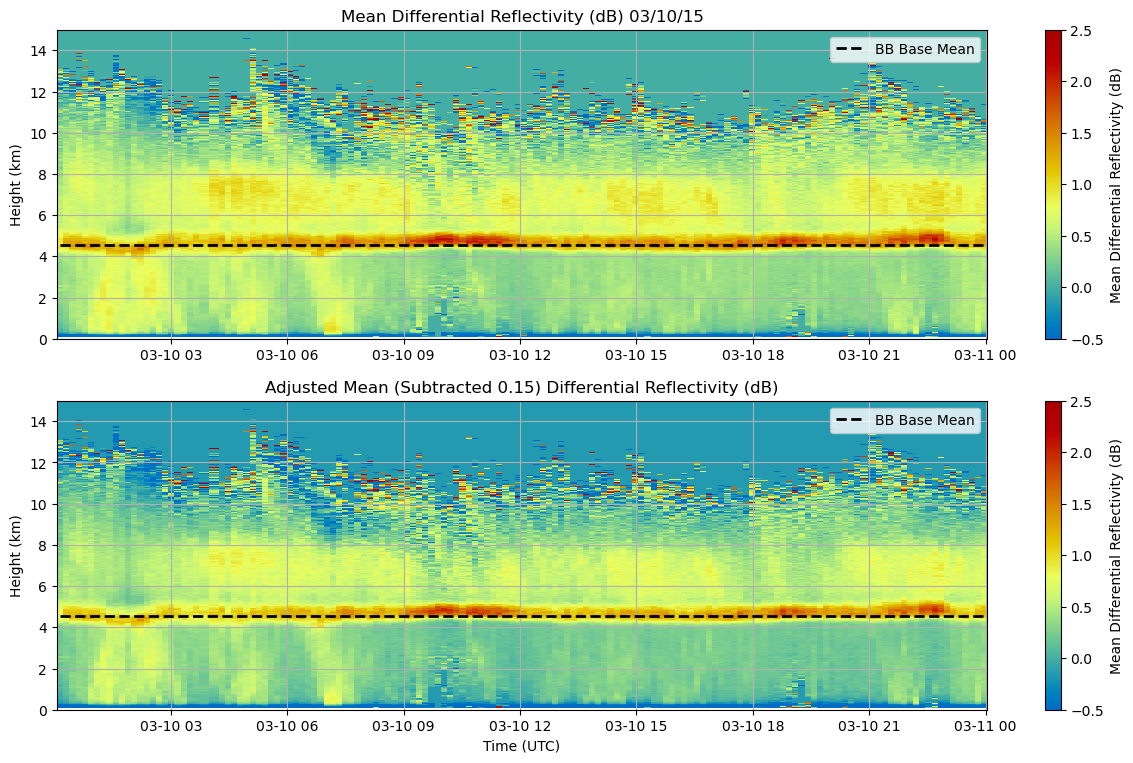

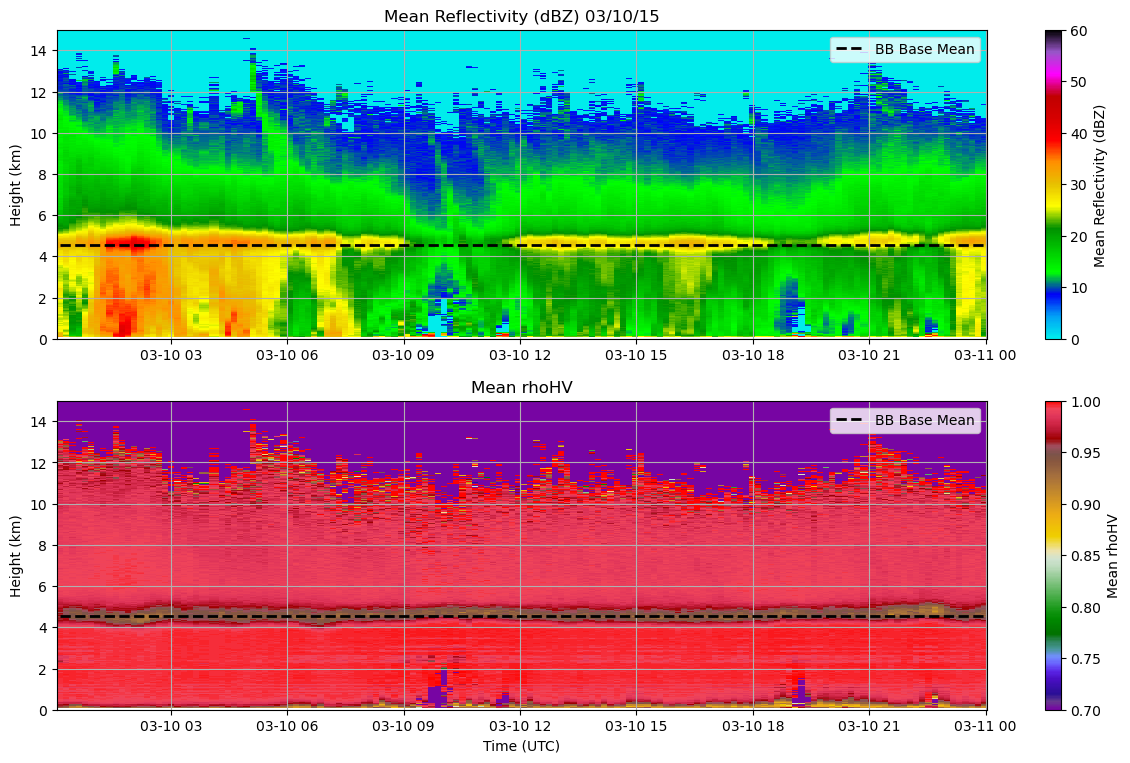

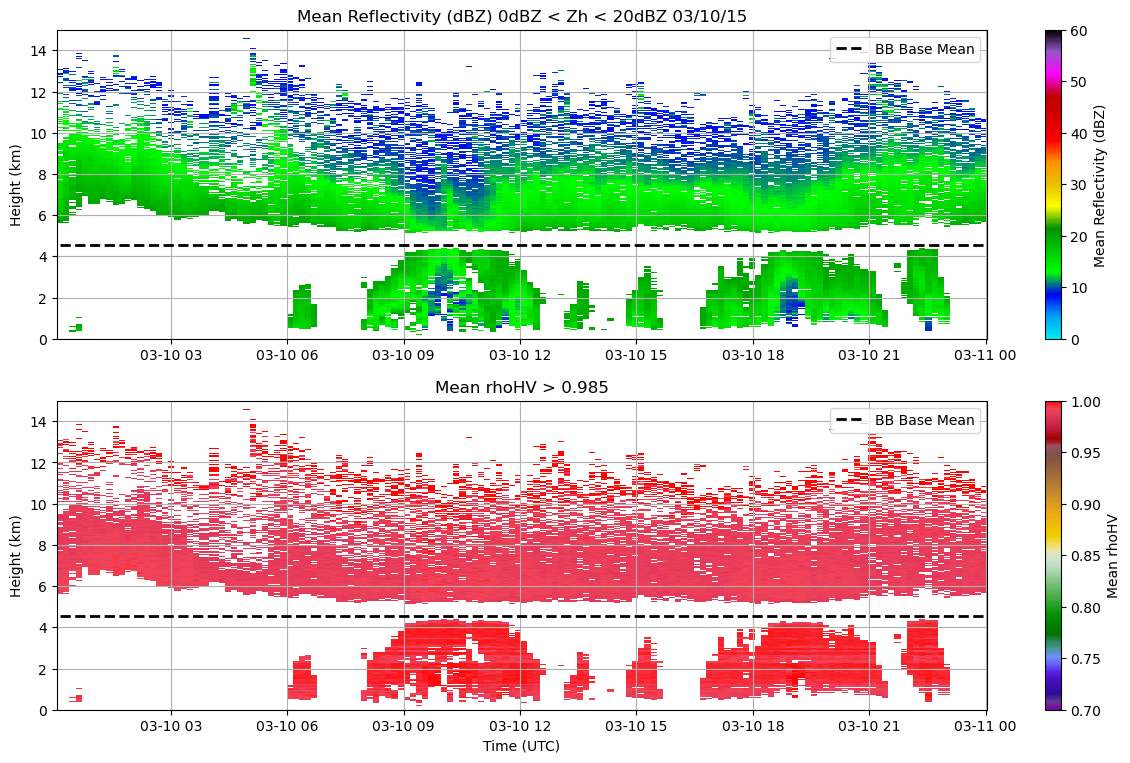

In [2]:
year  = '2015'
month = '03'
day   = '10'
yy = year[2:4] 

# KDOX case
#in_dir = '/Users/jpippitt/GPM-GV/KPOL/KDOX/240830/'
#base_dir = '/Users/jpippitt/GPM-GV/KDOX/'
# NPOL cases
#in_dir = '/Users/jpippitt/GPM-GV/KPOL/NPOL/231218/'
#in_dir = '/Users/jpippitt/GPM-GV/KPOL/NPOL/240227/'
#in_dir = '/Users/jpippitt/GPM-GV/KPOL/NPOL/240323/'
#in_dir = '/Users/jpippitt/GPM-GV/KPOL/NPOL/240506/'
#in_dir = '/Users/jpippitt/GPM-GV/KPOL/NPOL/240507/'
#in_dir = '/Users/jpippitt/GPM-GV/KPOL/NPOL/240605/'
#in_dir = '/Users/jpippitt/GPM-GV/KPOL/NPOL/240607/'
#base_dir = '/Users/jpippitt/GPM-GV/KPOL/NPOL/'
# KPOL cases
in_dir = '/Users/jpippitt/GPM-GV/KPOL/150310/'
base_dir = '/Users/jpippitt/GPM-GV/KPOL/'
plt_dir = base_dir + '/plots/' + year + '/' + month + '/'
os.makedirs(plt_dir, exist_ok=True)
txt_dir = base_dir + '/txt/' + year + '/' + month + '/'
os.makedirs(txt_dir, exist_ok=True)

wc = in_dir + '*.cf.gz'
all_files = sorted(glob.glob(wc))

# Create QVP dictionary
result = []
field_names = ['RH','CZ','DR','KD']
for file in all_files:
    cfy = pathlib.Path(file).suffix
    if cfy == '.gz':
        file_unzip = unzip_file(file)
        result.append(retrieve_qvp(file_unzip))
        os.remove(file_unzip)
    else:
        result.append(retrieve_qvp(file))

qvps = result 

# Organize data into a time series
times, time_series = get_time_series(qvps)

# Convert dictionary to xarray Dataset
ds = convert_to_xr(qvps,times , time_series)
ds_plot = ds

# Obtain BB height
mean_bb,bb_base_heights = find_BB_height(ds)
min_height = 0
max_height = mean_bb[0]
print(f"Mean BB Base Height: {max_height:.2f} m")

# Set data to nan outside Zh values 0 < Zh < 20 dBZ.
ds = ds.where((ds.CZ >= 0) & (ds.CZ <= 20), other=np.nan)

# Set data to nan when RH < 0.985.
ds = ds.where(ds.RH > 0.985, other=np.nan)

# Extract ZDR values within height range
zdr_values = extract_height_data(ds, min_height, max_height)

# Compute the calibration offset
offset = calculate_zdr_offset(zdr_values)
print(f"ZDR QVP offset: {offset:.2f} dB")

# Plot QVP time series
plot_data(plt_dir, times, ds_plot, qvps, mean_bb, offset,month,day,yy)

# Plot QVP CZ and RH
plot_data_cz(plt_dir, times, ds_plot, qvps, mean_bb, offset,month,day,yy)

# Plot QVP Thresholded CZ and RH
plot_data_thresh(plt_dir, times, ds, qvps, mean_bb, offset,month,day,yy)
    
# Output Bias to monthly txt file
txt_file = txt_dir + '/KPOL_ZDR_bias_' + month + '-' + year + '.txt'
with open(txt_file, 'a') as f:
    if day == '01': f.write('Date     ZDR Bias (dB)    BB Height (m)\n')
    f.write(f"{yy}{month}{day}  {offset:.2f}  {max_height:.2f}\n")

### NPOL Bird Bath Cases

In [3]:
# Jun 7, 2024: BB offset 0.0 dB, QVP offset: 0.09 dB, Height 0-4.0km
# Jun 5, 2024: BB offset +0.08 dB, QVP offset: -0.07 dB, Height 0-3.75km
# May 7, 2024: BB offset +0.28 dB, QVP offset: 0.02 dB, Height 0-3.0km
# May 6, 2024: BB offset +0.26 dB, QVP offset: 0.22 dB, Height 0-3.0km
# Mar 23, 2024: BB offset -0.30 dB, QVP offset: -0.35 dB, Height 0-1.75km
# Feb 27, 2024: BB offset -0.17 dB, QVP offset: -0.22 dB, Height 0-2.0km
# Dec 18, 2023: BB offset -0.01 dB, QVP offset: -0.17 dB, Height 0-2.50km